In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

In [3]:
DATASET_DIR = "../dataset/classification/mashroom"

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
file_name = "mushroom.csv"

In [4]:
HEADER = ["Attributes", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
          "gill-attachment", "gill-spacing", "gill-size", "gill-color", 
          "stalk-shape", "stalk-root", "stalk-surface-above-ring", 
          "stalk-surface-below-ring", "stalk-color-above-ring", 
          "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", 
          "ring-type", "spore-print-color", "population", "habitat"]

In [5]:
# os.makedirs(DATASET_DIR, exist_ok=True)
# df = pd.read_csv(url, header=None, names=HEADER)
# df.to_csv(f"{DATASET_DIR}/{file_name}", index=False)

In [6]:
# df = pd.read_csv(f"{DATASET_DIR}/{file_name}")
# df

In [7]:
df = pd.read_csv('../dataset/classification/mushroom/mushroom.csv')

In [8]:
features_ori = df.drop(columns=["Attributes","stalk_shape"])
onehot = OneHotEncoder(sparse=False)
features = onehot.fit_transform(features_ori)
features.shape

(8124, 115)

In [9]:
flag = (df["stalk_shape"]=="t").values
features[flag].shape

(4608, 115)

In [10]:
tsne = TSNE(random_state=0)
features_embedd = tsne.fit_transform(features)

In [11]:
df_embedd = pd.DataFrame(features_embedd, columns=["embedd_x","embedd_y"])
df_embedd["stalk_shape"] = df["stalk_shape"]
df_embedd["Attributes"] = df["Attributes"]

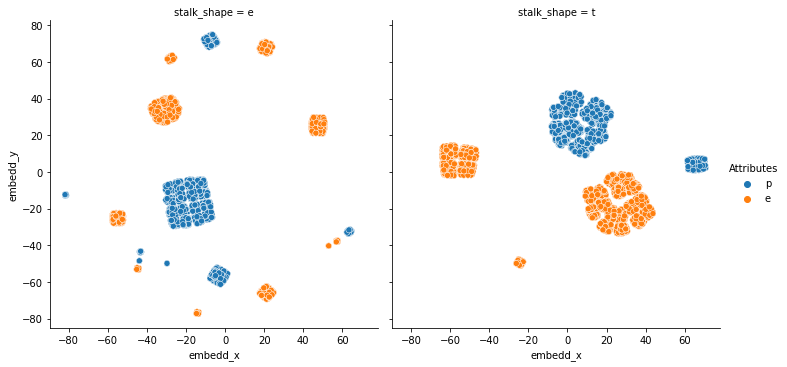

In [12]:
sns.relplot(x="embedd_x", y="embedd_y", col="stalk_shape", hue="Attributes", data=df_embedd)

In [13]:
tsne = TSNE(perplexity=10, random_state=0)
features_embedd = tsne.fit_transform(features)

In [14]:
df_embedd = pd.DataFrame(features_embedd, columns=["embedd_x","embedd_y"])
df_embedd["stalk_shape"] = df["stalk_shape"]
df_embedd["Attributes"] = df["Attributes"]

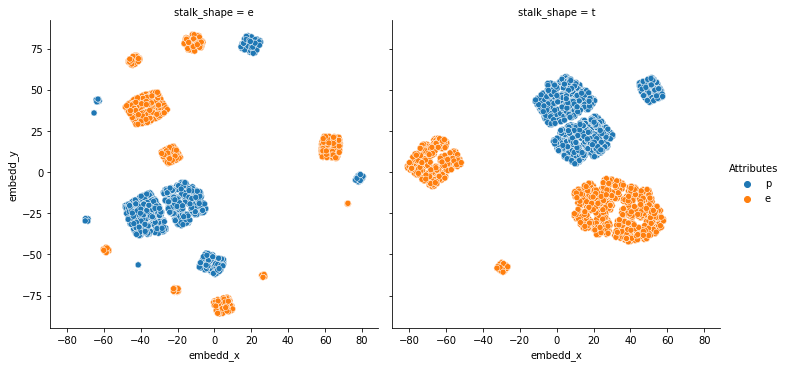

In [15]:
sns.relplot(x="embedd_x", y="embedd_y", col="stalk_shape", hue="Attributes", data=df_embedd)

# KL-divergence

In [16]:
from scipy.stats import entropy

In [18]:
df_cross = pd.crosstab(df["Attributes"],df["stalk_shape"])
df_cross

stalk_shape,e,t
Attributes,,
e,1616,2592
p,1900,2016


In [23]:
print(entropy(df_cross["t"], df_cross["e"]))
print(entropy(df_cross["e"], df_cross["t"]))

0.021224594790416357
0.02128970915944238


# GBDT

In [23]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
def _preprocess_dataset(df, drop_cols):
    """OrdinalEncoding・欠損値除去を行う関数

    Args:
        df (pd.DataFrame): 整形前データフレーム
        drop_cols (list) -- 処理を通さない変数

    Returns:
        pd.DataFrame: 整形後データフレーム
    """
    # 文字列はOrdinalEncoding
    object_cols = df.columns[df.dtypes==object]  # 文字列カラムを取得
    # y_featureとsplit_featureはこの処理を通さないようにする
    object_cols = [col for col in object_cols if col not in drop_cols]
    df_make = df.copy()
    enc = OrdinalEncoder()
    df_make.loc[:,object_cols] = enc.fit_transform(df_make[object_cols])
    # 欠損値は-9999
    df_make.fillna(-9999, inplace=True)

    return df_make

In [41]:
target_col = "Attributes"
split_col = "stalk_shape"

df_make = _preprocess_dataset(df, [target_col])
X = df_make.drop(columns=[target_col,]).values
y = df_make[target_col].values

In [47]:
model = GradientBoostingClassifier(n_iter_no_change=10)
model.fit(X,y)

GradientBoostingClassifier(n_iter_no_change=10)

In [48]:
model.feature_importances_

array([1.51936212e-05, 8.33393337e-19, 7.52255942e-05, 1.44285284e-04,
       2.01011665e-01, 9.70540791e-21, 6.66545295e-04, 7.79094342e-02,
       3.12998621e-01, 3.95072005e-03, 2.81338733e-02, 1.35327908e-04,
       7.88569310e-03, 7.37717049e-03, 7.49703882e-03, 0.00000000e+00,
       7.25877339e-08, 2.79308766e-03, 1.02107890e-04, 1.78842862e-01,
       1.62704703e-01, 7.75637316e-03])

<AxesSubplot:>

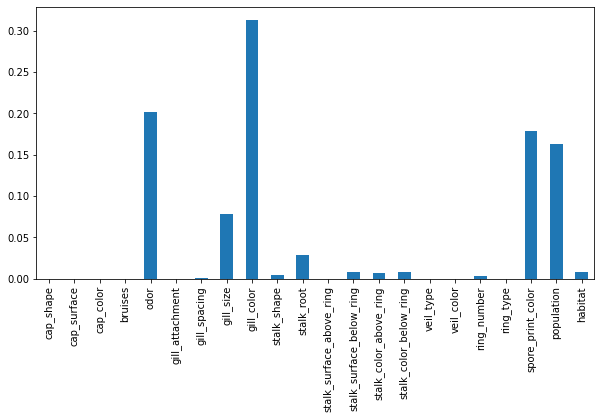

In [55]:
cols = df_make.drop(columns=[target_col]).columns
importance = pd.Series(model.feature_importances_, index=cols)
importance.plot.bar(figsize=(10,5))